## Test case to re-identify the clusters using CNN (model based on [AlexNet](https://en.wikipedia.org/wiki/AlexNet))
- using **CNN2** model (implemented here) 
- using **CNN4** model

In [1]:
#create dask cluster
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33971 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:33971/status,
Dashboard: http://127.0.0.1:33971/status,Workers: 4
Total threads: 4,Total memory: 29.94 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34125,Workers: 4
Dashboard: http://127.0.0.1:33971/status,Total threads: 4
Started: Just now,Total memory: 29.94 GiB
Comm: tcp://127.0.0.1:43291,Total threads: 1
Dashboard: http://127.0.0.1:33615/status,Memory: 7.48 GiB
Nanny: tcp://127.0.0.1:36687,


In [2]:
import os
import PIL
from PIL import Image
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import numpy as np
import time
%matplotlib inline

### The 378 x 248 x 3 (RGB) sized contour plot image is downsampled to size 28 x 28 x 3 using bicubic interpolation

In [6]:
#clear previous model
keras.backend.clear_session()

In [7]:
#CNN2 based on alexnet
# 2 Convolution layers with 'relu' activation, 16 and 32 filters each with kernel size 5
# 2 MaxPooling layers with kernel size 2
# one dense layer 
# output layer has 4 neurons (4 classes)


n_classes  = 4
drop_p = 0.5
lambda_val = 0.02

cnn2_model = tf.keras.Sequential([
  layers.experimental.preprocessing.Normalization(mean = 0,variance = 1), #normalization
  layers.Conv2D(16, 5, activation='relu',padding ='same',activity_regularizer= regularizers.L2(lambda_val)),
  layers.MaxPooling2D(strides=1),
  layers.Conv2D(32, 5, activation='relu',padding ='same',activity_regularizer= regularizers.L2(lambda_val)),
  layers.MaxPooling2D(strides=1),
  layers.Flatten(),
  layers.Dense(1024, activation='relu',activity_regularizer= regularizers.L2(lambda_val)),
  layers.Dropout(drop_p),
  layers.Dense(n_classes,activation='softmax')
])

cnn2_model

In [8]:
learn_rate = 0.005
opt = tf.keras.optimizers.Adam(learning_rate=learn_rate)

cnn2_model.compile(
  optimizer=opt,
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])

In [9]:
history = cnn2_model.fit(
  image_train_ds,
  validation_data=image_val_ds,
  epochs = 15
)


Epoch 1/15
26/26 [==============================] - 9s 276ms/step - loss: 123086.5260 - accuracy: 0.2432 - val_loss: 1.3811 - val_accuracy: 0.2177
Epoch 2/15
26/26 [==============================] - 7s 248ms/step - loss: 1.3755 - accuracy: 0.2864 - val_loss: 1.3800 - val_accuracy: 0.2177
Epoch 3/15
26/26 [==============================] - 7s 251ms/step - loss: 1.3763 - accuracy: 0.2669 - val_loss: 1.3784 - val_accuracy: 0.2177
Epoch 4/15
26/26 [==============================] - 7s 246ms/step - loss: 1.3652 - accuracy: 0.2455 - val_loss: 1.3787 - val_accuracy: 0.2177
Epoch 5/15
26/26 [==============================] - 7s 248ms/step - loss: 1.3688 - accuracy: 0.2921 - val_loss: 1.3819 - val_accuracy: 0.2177
Epoch 6/15
26/26 [==============================] - 7s 248ms/step - loss: 1.3709 - accuracy: 0.3017 - val_loss: 1.3807 - val_accuracy: 0.2177
Epoch 7/15
26/26 [==============================] - 7s 251ms/step - loss: 1.3672 - accuracy: 0.2784 - val_loss: 1.3801 - val_accuracy: 0.2177
E

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


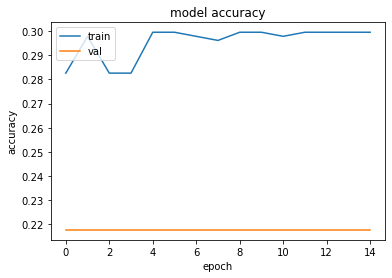

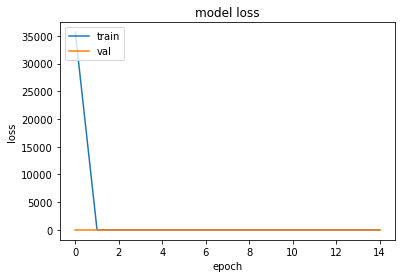

In [10]:
#list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [11]:
from tensorflow.keras import backend as K

print("No. of layers: ", len(cnn2_model.layers))
print("Model summary: ", cnn2_model.summary())

No. of layers:  9
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 28, 28, 3)         7         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 26, 26, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 21632)             0         
_________________________________________________________________
dense (Dense)                (None, 10

In [12]:
#evaluate of test data
eval = cnn2_model.evaluate(image_test_ds)

8/8 [==============================] - 1s 28ms/step - loss: 1.3678 - accuracy: 0.2857


In [13]:
#run on prediction dataset
pred_labels = []
true_labels = []
for images_batch,labels_batch in image_pred_ds:
    #print(len(images_batch),len(labels_batch))
    p_labels = cnn2_model.predict(images_batch)
    pred_labels.append(np.argmax(p_labels,axis = 1))
    true_labels.append(np.array(labels_batch))

true_labels = np.concatenate(true_labels).ravel()
pred_labels = np.concatenate(pred_labels).ravel()
print("original labels :",true_labels)
print("predicted labels :",pred_labels)

original labels : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
predicted labels : [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [14]:
#confusion matrix
res = tf.math.confusion_matrix(pred_labels,true_labels)
print("confusion matrix:",res)

pred_acc = np.array(tf.math.count_nonzero(pred_labels  == true_labels))/len(true_labels)
print("accuracy:",pred_acc)

confusion matrix: tf.Tensor(
[[ 0  0  0  0]
 [ 0  0  0  0]
 [ 0  0  0  0]
 [21 22 29 20]], shape=(4, 4), dtype=int32)
accuracy: 0.21739130434782608
